In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cell 2: Load Data
train_data = pd.read_csv('data_minihackathon_train.csv')
test_data = pd.read_csv('data_minihackathon_test.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("\nTraining data info:")
print(train_data.info())
print("\nMissing values in training data:")
print(train_data.isnull().sum())
print("\nTest data missing values:")
print(test_data.isnull().sum())

Training data shape: (1500, 14)
Test data shape: (377, 13)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1500 non-null   int64  
 1   Age            1498 non-null   float64
 2   Gender         1499 non-null   float64
 3   Education      1480 non-null   float64
 4   Country        1498 non-null   float64
 5   Ethnicity      1500 non-null   float64
 6   Nscore         1499 non-null   float64
 7   Escore         1499 non-null   float64
 8   Oscore         1499 non-null   float64
 9   Ascore         1499 non-null   float64
 10  Cscore         1499 non-null   float64
 11  Impulsive      1499 non-null   float64
 12  SS             1500 non-null   float64
 13  drug_category  1500 non-null   object 
dtypes: float64(12), int64(1), object(1)
memory usage: 164.2+ KB
None

Missing values in training data:
ID   


Target distribution:
drug_category
Hallucinogens    0.460667
Stimulants       0.378000
Depressants      0.161333
Name: proportion, dtype: float64


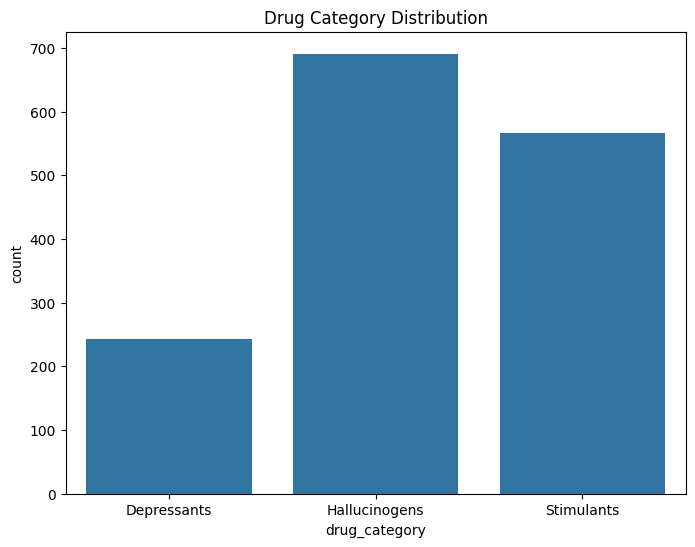

In [3]:
# Cell 3: Exploratory Data Analysis - Target Distribution
print("\nTarget distribution:")
print(train_data['drug_category'].value_counts(normalize=True))

plt.figure(figsize=(8, 6))
sns.countplot(x='drug_category', data=train_data)
plt.title('Drug Category Distribution')
plt.show()

In [4]:
# Cell 4: Drop Irrelevant Features
# Based on user instruction and analysis, Country and Ethnicity likely don't contribute much to personality-based drug prediction
features_to_drop = ['Country', 'Ethnicity']
train_data = train_data.drop(features_to_drop, axis=1)
test_data = test_data.drop(features_to_drop, axis=1)

print("\nFeatures after dropping:")
print(train_data.columns)


Features after dropping:
Index(['ID', 'Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore',
       'Ascore', 'Cscore', 'Impulsive', 'SS', 'drug_category'],
      dtype='object')


In [5]:
# Cell 5: Handle Missing Values
# Impute numerical features with median (more robust to outliers)
num_cols = ['Age', 'Gender', 'Education', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']

imputer = SimpleImputer(strategy='median')
train_data[num_cols] = imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = imputer.transform(test_data[num_cols])

print("\nMissing values after imputation:")
print(train_data.isnull().sum())


Missing values after imputation:
ID               0
Age              0
Gender           0
Education        0
Nscore           0
Escore           0
Oscore           0
Ascore           0
Cscore           0
Impulsive        0
SS               0
drug_category    0
dtype: int64


In [6]:
# Cell 6: Handle Outliers
# Use Z-score to detect and clip outliers for numerical features
z_threshold = 3
for col in num_cols:
    z_scores = np.abs(stats.zscore(train_data[col]))
    outliers = z_scores > z_threshold
    # Clip outliers to threshold
    train_data.loc[outliers, col] = np.sign(train_data.loc[outliers, col]) * (train_data[col].std() * z_threshold + train_data[col].mean())
    
    # Apply same to test (using train stats)
    z_scores_test = np.abs(stats.zscore(test_data[col]))
    outliers_test = z_scores_test > z_threshold
    test_data.loc[outliers_test, col] = np.sign(test_data.loc[outliers_test, col]) * (train_data[col].std() * z_threshold + train_data[col].mean())

print("\nData after outlier handling.")


Data after outlier handling.


In [7]:
# Cell 7: Prepare Features and Target
X = train_data.drop(['ID', 'drug_category'], axis=1)
y = train_data['drug_category']

# Encode target if needed (but since it's categorical, models can handle strings, but for consistency)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"\nTrain shape: {X_train.shape}, Val shape: {X_val.shape}")


Train shape: (1200, 10), Val shape: (300, 10)


In [8]:
# Cell 8: Handle Class Imbalance with SMOTE
# We'll use SMOTE in pipeline for oversampling minority classes
smote = SMOTE(random_state=42)

In [9]:
# Cell 9: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# For test
test_ids = test_data['ID']
X_test = test_data.drop('ID', axis=1)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Cell 10: Model 1 - Random Forest with Grid Search
rf_pipeline = Pipeline([
    ('smote', smote),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__class_weight': ['balanced', None]
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print("\nBest RF Params:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

y_val_pred_rf = rf_best.predict(X_val_scaled)
print("\nRF Classification Report:\n", classification_report(y_val, y_val_pred_rf))
print("RF Accuracy:", accuracy_score(y_val, y_val_pred_rf))


Best RF Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__n_estimators': 100}

RF Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.18      0.25        49
           1       0.71      0.68      0.70       138
           2       0.63      0.81      0.71       113

    accuracy                           0.65       300
   macro avg       0.57      0.56      0.55       300
weighted avg       0.63      0.65      0.63       300

RF Accuracy: 0.6466666666666666


In [11]:
# Cell 11: Model 2 - Logistic Regression with Grid Search
lr_pipeline = Pipeline([
    ('smote', smote),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

lr_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': ['balanced', None]
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)

print("\nBest LR Params:", lr_grid.best_params_)
lr_best = lr_grid.best_estimator_

y_val_pred_lr = lr_best.predict(X_val_scaled)
print("\nLR Classification Report:\n", classification_report(y_val, y_val_pred_lr))
print("LR Accuracy:", accuracy_score(y_val, y_val_pred_lr))


Best LR Params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__solver': 'liblinear'}

LR Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.12      0.13        49
           1       0.73      0.67      0.70       138
           2       0.65      0.77      0.71       113

    accuracy                           0.62       300
   macro avg       0.51      0.52      0.51       300
weighted avg       0.61      0.62      0.61       300

LR Accuracy: 0.62


In [12]:
# Cell 12: Model 3 - SVM with Grid Search
svm_pipeline = Pipeline([
    ('smote', smote),
    ('classifier', SVC(random_state=42, probability=True))
])

svm_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__class_weight': ['balanced', None]
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

print("\nBest SVM Params:", svm_grid.best_params_)
svm_best = svm_grid.best_estimator_

y_val_pred_svm = svm_best.predict(X_val_scaled)
print("\nSVM Classification Report:\n", classification_report(y_val, y_val_pred_svm))
print("SVM Accuracy:", accuracy_score(y_val, y_val_pred_svm))


Best SVM Params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'rbf'}

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.16      0.16        49
           1       0.73      0.66      0.69       138
           2       0.65      0.71      0.68       113

    accuracy                           0.60       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.61      0.60      0.60       300

SVM Accuracy: 0.5966666666666667


In [13]:
# Cell 13: Ensemble - Voting Classifier
# Combine the best models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_best.named_steps['classifier']),
        ('lr', lr_best.named_steps['classifier']),
        ('svm', svm_best.named_steps['classifier'])
    ],
    voting='soft'  # Soft voting for probabilities
)

# Fit with SMOTE separately
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
voting_clf.fit(X_train_resampled, y_train_resampled)

y_val_pred_vote = voting_clf.predict(X_val_scaled)
print("\nVoting Classifier Report:\n", classification_report(y_val, y_val_pred_vote))
print("Voting Accuracy:", accuracy_score(y_val, y_val_pred_vote))


Voting Classifier Report:
               precision    recall  f1-score   support

           0       0.19      0.14      0.16        49
           1       0.74      0.69      0.71       138
           2       0.65      0.78      0.71       113

    accuracy                           0.63       300
   macro avg       0.53      0.54      0.53       300
weighted avg       0.62      0.63      0.62       300

Voting Accuracy: 0.6333333333333333


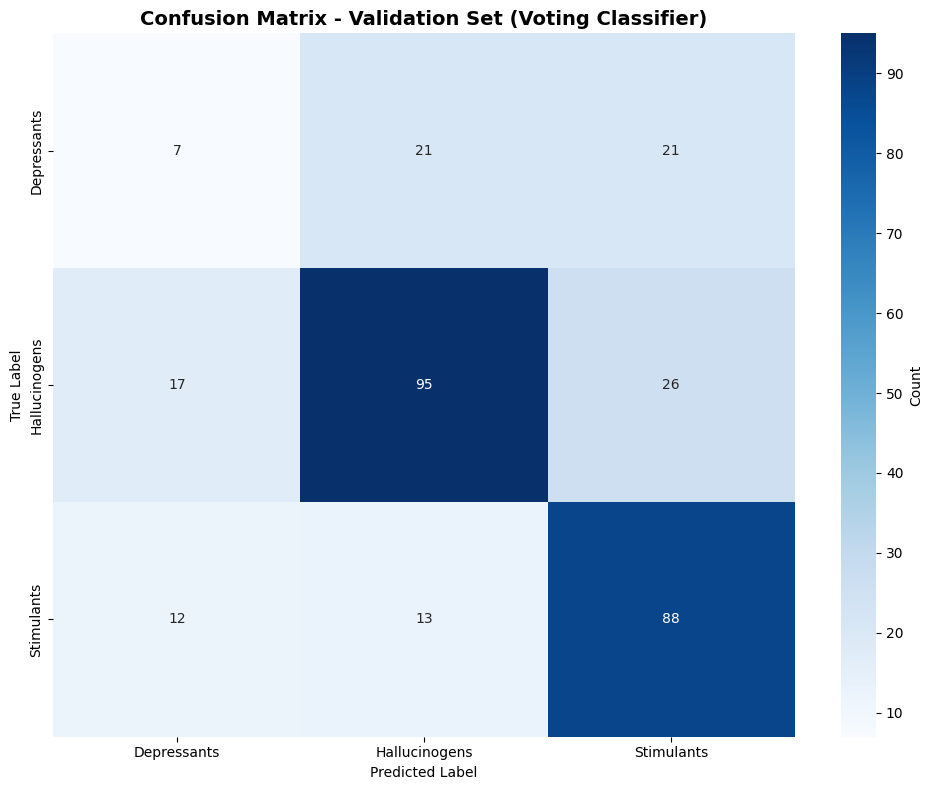

In [14]:
# Cell 14: Confusion Matrix for Best Model (Voting)
cm = confusion_matrix(y_val, y_val_pred_vote)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Validation Set (Voting Classifier)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [15]:
# Cell 15: Per-Class Accuracy for Voting
print("\nPer-Class Accuracy (Voting):")
print("-" * 40)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_val == i
    if class_mask.sum() > 0:
        class_acc = (y_val_pred_vote[class_mask] == i).mean()
        print(f"{class_name:20} {class_acc:.4f} ({class_acc*100:.2f}%)")


Per-Class Accuracy (Voting):
----------------------------------------
Depressants          0.1429 (14.29%)
Hallucinogens        0.6884 (68.84%)
Stimulants           0.7788 (77.88%)


In [16]:
# Cell 16: Make Predictions on Test Set with Voting Classifier
print("\nMaking predictions on test set...")
test_predictions = voting_clf.predict(X_test_scaled)

# Decode predictions
test_predictions_decoded = label_encoder.inverse_transform(test_predictions)

print(f"Test predictions shape: {test_predictions.shape}")


Making predictions on test set...
Test predictions shape: (377,)


In [17]:
# Cell 17: Create Submission File
submission = pd.DataFrame({
    'ID': test_ids,
    'drug_category': test_predictions_decoded
})

submission.to_csv('predictions3.csv', index=False)
print("✓ Predictions saved to 'predictions3.csv'")

✓ Predictions saved to 'predictions3.csv'


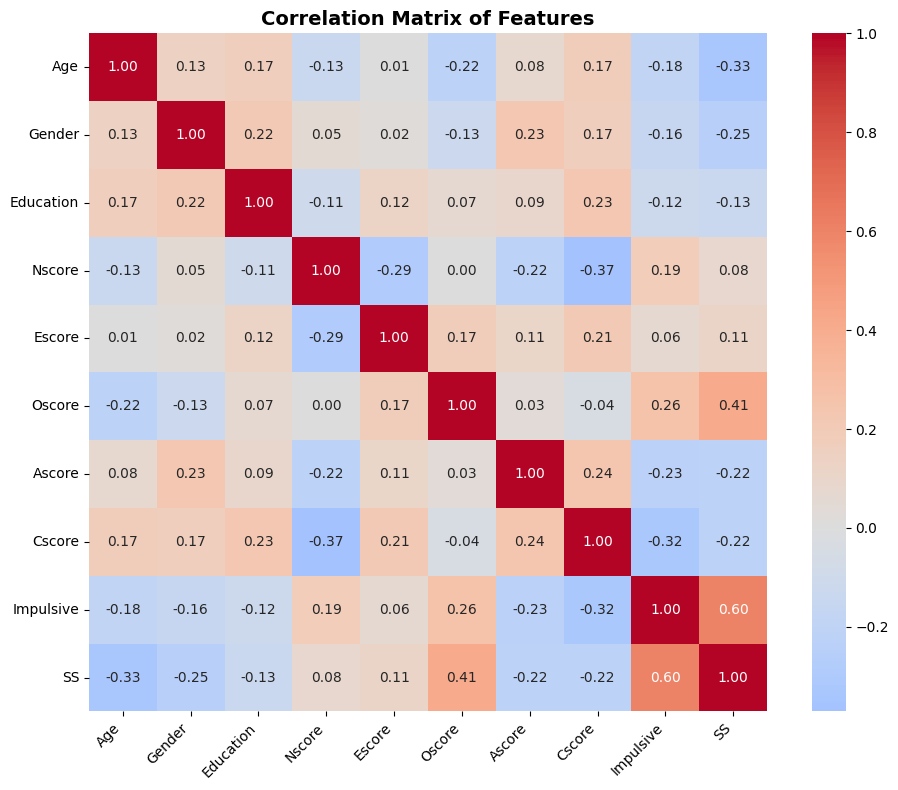

In [18]:
# Cell 1: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cell 2: Load Data
train_data = pd.read_csv('data_minihackathon_train.csv')

# Cell 3: Drop Irrelevant Features
# Drop 'Country' and 'Ethnicity' as instructed, and 'ID' and 'drug_category' since they are not numerical predictors
features_to_drop = ['ID', 'drug_category', 'Country', 'Ethnicity']
data_for_correlation = train_data.drop(features_to_drop, axis=1)

# Cell 4: Handle Missing Values
# Impute missing values with the median (robust to outliers)
data_for_correlation = data_for_correlation.fillna(data_for_correlation.median())

# Cell 5: Compute Correlation Matrix
correlation_matrix = data_for_correlation.corr()

# Cell 6: Plot Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()